## **Workshop on how to Bridge the gap between Neuroscience & Computational Intelligence for BCI with Google TensorFlow ?**
## See more detail about workshop here: https://thinknew.github.io/BCIWorkshop/
## This notebook is convereted into TensorFlow and original based on notebook published as a part of blog here: http://learn.neurotechedu.com/machinelearning/

**# Step 1** : Setting Up the Environment

The prerequisite packages to this tutorial are:


*   [**MNE**](https://mne.tools/stable/install/mne_python.html#installing-mne-python-and-its-dependencies): EEG Data Package
*   [**NumPy**](https://www.scipy.org/install.html): Numerical Computing (SciPy Download Page)
*   [**SciPy**](https://www.scipy.org/install.html): Scientific Computing
*   [**MatPlotLib**](https://matplotlib.org/users/installing.html): General Purpose Machine Learning Library
*   [**Scikit-Learn**](https://scikit-learn.org/stable/install.html): General Purpose Machine Learning Library
*   [**Tensorflow 2.0**](https://www.tensorflow.org/guide/effective_tf2/): Deep Learning Library from Google Brain

All packages but MNE are available through Google Colab and thus we only need to install MNE.

In [ ]:
a = 5

In [ ]:
# Run these from the console if following along locally
!pip install mne
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.2 MB/s 


For the purposes of this workshop, we will be turning off warnings.

In [ ]:
# You'll want to comment this out if you plan on modifying this code, to get valuable feedback
import warnings
warnings.filterwarnings('ignore')

Import all of our required modules. This includes various submodules that we'll need including the RobustScaler object from scikit.

In [ ]:
from collections import OrderedDict
from pylab import rcParams
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import mne
from sklearn.preprocessing import RobustScaler

**# Step 2**: Reproducibility Matters

In [ ]:
# Set seed to reproduce behaviour
tf.random.set_seed(100)

Initialize parameters including EEG related Metadata.


*   **eeg_sample_count**:  Number of samples we're training our network with
*   **learning_rate**:     How fast the network tends to change its weights
*   **eeg_sample_length**: Number of datapoints per sample
*   **number_of_classes**: Number of output classes (a scalar value that represents probability of input belonging to p300)
*   **hidden1**: Number of neurons in the first hidden layer
*   **hidden2**: Number of neurons in the second hidden layer
*   **hidden3**: Number of neurons in the third hidden layer
*   **output**: Number of neurons in the output layer

In [ ]:
# Initialize parameters
eeg_sample_count = 240 # How many samples are we training
learning_rate = 1e-3 # How hard the network will correct its mistakes while learning
eeg_sample_length = 226 # Number of eeg data points per sample
number_of_classes = 1 # We want to answer the "is this a P300?" question
hidden1 = 500 # Number of neurons in our first hidden layer
hidden2 = 1000 # Number of neurons in our second hidden layer
hidden3 = 100 # Number of neurons in our third hidden layer
penultimate = 10 # Number of neurons in our output layer

# **# Step 3:** Retrieve Data from the MNE EEG Dataset 

The MNE library is a resource that specializes on brain signal processing, and provides access to sample databases. We will use one of these P300 databases to train our network.

In [ ]:
data_path = mne.datasets.sample.data_path()
data_path

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 12.5GB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


MNEPosixPath('/root/mne_data/MNE-sample-data')

In order to obtain this database using `Python`, we need to set the path to the specific dataset we are going to use. In this case it is the sample audiovisual database, where the brainwaves have been filtered from 0 to 40 Hz. 

The data we obtain is **raw**. This means that it is simply a collection of streamed brain signal samples from many EEG channels, as opposed to signals sliced or focused to an event of interest. 

In [ ]:
!cp /root/mne_data/MNE-sample-data/ /content/MNE_data -r

^C


In [ ]:
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'

# Obtain a reference to the database and preload into RAM
raw_data = mne.io.read_raw_fif(raw_fname, preload=True) 

# EEGs work by detecting the voltage between two points. The second reference
# point is set to be the average of all voltages using the following function.
# It is also possible to set the reference voltage to a different number.
raw_data.set_eeg_reference()

Opening raw data file /root/mne_data/MNE-sample-data//MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


<ipython-input-10-1ea6c855818e>:1: DeprecationWarning: data_path functions now return pathlib.Path objects which do not natively support the plus (+) operator, switch to using forward slash (/) instead. Support for plus will be removed in 1.2.
  raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
<ipython-input-10-1ea6c855818e>:2: DeprecationWarning: data_path functions now return pathlib.Path objects which do not natively support the plus (+) operator, switch to using forward slash (/) instead. Support for plus will be removed in 1.2.
  event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'


Reading 0 ... 41699  =      0.000 ...   277.709 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Created an SSP operator (subspace dimension = 3)


<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.9 MB, data loaded>

Here we load the database and save it in a variable called raw_data. The pick function allows us to choose the sources of interest. For this tutorial we are picking the data from the EEG electrodes. EOG is also included as those are captured using the same electrodes.

This dataset also includes the data from MEG (magnetoencephalography). However, MEG is still very far from being an accessible technology, due to the device being the size of a room. It also requires superconductors to function, similar to fMRI.

In [ ]:
# Define what data we want from the dataset
raw_data = raw_data.pick(picks=["eeg","eog"])
picks_eeg_only = mne.pick_types(raw_data.info, 
                                eeg=True, 
                                eog=True, 
                                meg=False, 
                                exclude='bads')

The raw EEG file comes with events that allow us to know when something happened during the EEG recording. For example, events with id 5 correspond to when participants were presented with smiley faces, while events 1 through 4 corresponds to trials were participants were presented with a checkerboard either on the left side or the right side of the screen and with a tone presented to either the left ear or the right ear. 
We know that the trials were participants were presented with a smiley (events with id 5) will elicit a P300. So we will start by slicing (or epoching) the data 0.5 seconds before the image was presented (to have a baseline) and 1 second after the image was presented. We can change this to values closer to 0.3 seconds, which would crop exactly to where the P300 is. 

In [ ]:
events = mne.read_events(event_fname)
event_id = 5
tmin = -0.5 
tmax = 1
epochs = mne.Epochs(raw_data, events, event_id, tmin, tmax, proj=True,
                    picks=picks_eeg_only, baseline=(None, 0), preload=True,
                    reject=dict(eeg=100e-6, eog=150e-6), verbose = False)
print(epochs)

<Epochs |  12 events (all good), -0.499488 - 0.998976 sec, baseline -0.499488 – 0 sec, ~4.2 MB, data loaded,
 '5': 12>


This data has only 12 P300 samples and 64 Sensors/Channel. However, we will use only one sensor/channel in network.

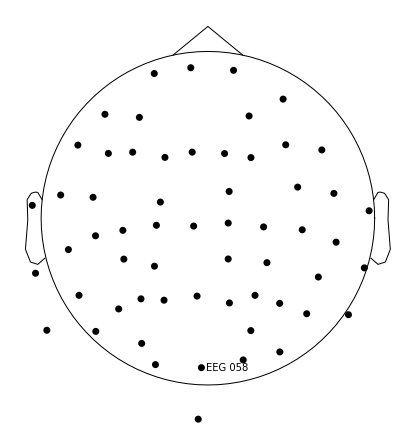

In [ ]:
# This is the channel used to monitor the P300 response
channel = "EEG 058"

# Display a graph of the sensor position we're using
sensor_position_figure = epochs.plot_sensors(show_names=[channel])

Below is a heat graph representing the 12 P300 events found within the dataset. If you look closely around the `0.3sec -> 0.4sec` mark, you can see there is a noticable deflection in the signal. **That is the P300 component**, and the difficulty of detecting it is immediately clear, even with the line graph below the heat graph being the average of the 12 samples.

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


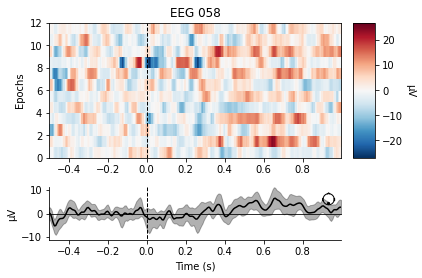

[<Figure size 432x288 with 4 Axes>]

In [ ]:
epochs.plot_image(picks=channel)

Let's extract non P300 smaples

In [ ]:
event_id=[1,2,3,4]
epochsNoP300 = mne.Epochs(raw_data, events, event_id, tmin, tmax, proj=True,
                    picks=picks_eeg_only, baseline=(None, 0), preload=True,
                    reject=dict(eeg=100e-6, eog=150e-6), verbose = False)
print(epochsNoP300)

<Epochs |  208 events (all good), -0.499488 - 0.998976 sec, baseline -0.499488 – 0 sec, ~24.5 MB, data loaded,
 '1': 47
 '2': 56
 '3': 57
 '4': 48>


There are significantly more Non-P300 events in this dataset, so we will only be using a subset to keep a needed balance between class data. The most important thing to notice about the plot below is that there is no significant deflection around the `0.3sec -> 0.4sec` time interval for the average of the data. 

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


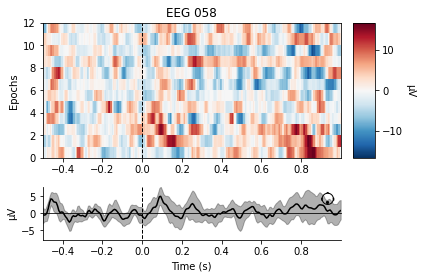

[<Figure size 432x288 with 4 Axes>]

In [ ]:
epochsNoP300[0:12].plot_image(picks=channel)

Here is one more useful all-in-one graph to visualize what these samples look like. Note that the image described in the sample problem earlier in the tutorial is shown at `time = 0sec`. The blue line corresponds to when the subject was shown a smiley face, and the orange line corresponds to when the subject was shown a checkerboard.

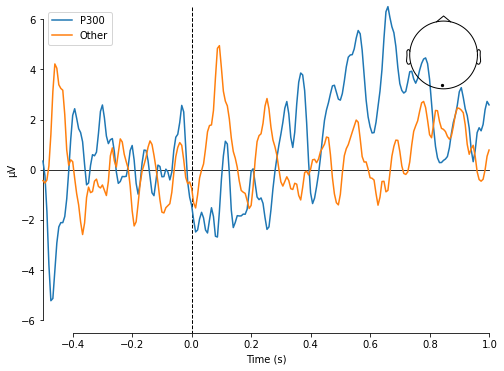

[<Figure size 576x432 with 2 Axes>]

In [ ]:
mne.viz.plot_compare_evokeds({'P300': epochs.average(picks=channel), 'Other': epochsNoP300[0:12].average(picks=channel)})

We've got a few more steps to take to fully transform our dataset data into something easily digestible by the neural network. We need to:


*   Scale the data while being mindful of possible outliers. If we just scale the data using the minimum and the maximum values of our dataset, we run the risk that our data gets defined by outliers and the regular values get squeezed in the center. To avoid this, we can use some statistical values (such as anything a few standard deviations from the  mean) to scale our data. 
*   Create a label variable, where the P300 samples are labeled as 1 and the Non-P300 samples are labeled as 0.
*   Combine the data into a single data structure.
*   Perform various data type conversions.

The code block below does all of this.

In [ ]:
eeg_data_scaler = RobustScaler()

# We have 12 p300 samples
p300s = np.squeeze(epochs.get_data(picks=channel))
raw_p300_data = np.copy(p300s)

# We have 208 non-p300 samples
others = np.squeeze(epochsNoP300.get_data(picks=channel))

# Scale the p300 data using the RobustScaler
p300s = p300s.transpose()
p300s = eeg_data_scaler.fit_transform(p300s)
p300s = p300s.transpose()

# Scale the non-p300 data using the RobustScaler
others = others.transpose()
others = eeg_data_scaler.fit_transform(others)
others = others.transpose()

## Prepare the train and test tensors
# Specify Positive P300 train and test samples
p300s_train = p300s[0:9]
p300s_test = p300s[9:12]
p300s_test = p300s_test.astype('float')

# Specify Negative P300 train and test samples
others_train = others[30:39]
others_test = others[39:42]
others_test = others_test.astype('float')

# Combine everything into their final structures
training_data = np.concatenate((p300s_train, others_train), axis = 0).astype('float')
positive_testing_data = p300s_test.astype('float')
negative_testing_data = others_test.astype('float')

# Print the size of each of our data structures
print("training data count: " + str(training_data.shape[0]))
print("positive testing data count: " + str(positive_testing_data.shape[0]))
print("negative testing data count: " + str(negative_testing_data.shape[0]))

# Generate training labels
labels = np.zeros((training_data.shape[0],1)).astype('float')
labels[0:10] = 1.0
print("training labels count: " + str(labels.shape[0]))

training data count: 18
positive testing data count: 3
negative testing data count: 3
training labels count: 18


**# Step 4 :** Creating our Deep Neural Network

This neural network has several distinct components that can be customized. Below, we define the network graph as sets of linear nodes and activation nodes. The defined graph roughly coresponds to this image: 

Our input data will be traveling along this graph, accumulating biases, scaled by weights, and being transformed by activation functions, until it passes through the final output node. It is then passed through a sigmoid function which scales the final value into a number between 0 and 1.

This final number is the p300 predictor.





In [ ]:
## Define the network
tutorial_model = keras.Sequential()

# Input Layer (Size 226 -> 500)
tutorial_model.add(layers.Dense(hidden1, activation="selu", name="Input_Layer"))

# Hidden Layer (Size 500 -> 1000)
tutorial_model.add(layers.Dense(hidden2, activation="relu", name="Hidden_Layer1"))

# Hidden Layer (Size 1000 -> 100)
tutorial_model.add(layers.Dense(hidden3, activation="relu", name="Hidden_Layer2"))

# Hidden Layer (Size 100 -> 10)
tutorial_model.add(layers.Dense(penultimate, activation="relu", name="Hidden_Layer3"))

# Output Layer (Size 10 -> 1)
tutorial_model.add(layers.Dense(number_of_classes, activation="sigmoid", name="Output_Layer"))

Next, let's define training loss function as MSE (mean squared error).

Keras provide an efficient wrapper to combine loss and training with the model.complie() function. 

It automatically calculates the loss and updates the network's weights at every iteration.

In [ ]:
# Define a loss function
#loss_function = keras.losses.MeanSquaredError()
# Define a learning function, needs to be reinitialized every load
optimizer = keras.optimizers.Adam(lr=learning_rate)
# After the model is created, we then config the model with losses and metrics
tutorial_model.compile(optimizer=optimizer,
             loss='mse',
             metrics=['mse'])

# Save the network's default state so we can retrain from the default weights
#tutorial_model.save("/home/tutorial_model_default_state")

Using the network definition created in Step 5, we'll train on our real EEG data this time, beginning from defaulted weights, prior to any training with the sample data we created.

**# Step 5:** Classify the Dataset with the Neural Network

Below is the loss graph for dataset training session


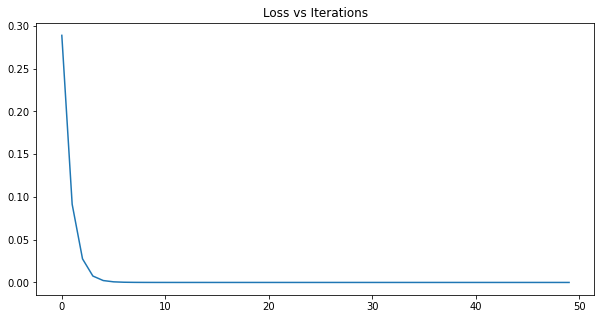

In [ ]:
# Make sure we're starting from untrained every time
#tutorial_model = keras.models.load_model('/home/tutorial_model_default_state')

mse_list = tutorial_model.fit(training_data, labels, epochs = 50, verbose=0)

# Define a learning function, needs to be reinitialized every load
# optimizer = torch.optim.Adam(tutorial_model.parameters(), lr = learning_rate)

# Use our training procedure with the sample data
print("Below is the loss graph for dataset training session")
loss_data = mse_list.history['loss']
# Plot a nice loss graph at the end of training
rcParams['figure.figsize'] = 10, 5
plt.title("Loss vs Iterations")
plt.plot(list(range(0, len(loss_data))), loss_data)
plt.show()

Alright, the moment of truth! Let's classify our test data sets.

In [ ]:
# Classify our positive test dataset and print the results
classification_1 = tutorial_model.predict(positive_testing_data)
for index, value in enumerate(classification_1.data.tolist()):
  print("P300 Positive Classification {1}: {0:.2f}%".format(value[0] * 100, index + 1))

print()

# Classify our negative test dataset and print the results
classification_2 = tutorial_model.predict(negative_testing_data)
for index, value in enumerate(classification_2.data.tolist()):
  print("P300 Negative Classification {1}: {0:.2f}%".format(value[0] * 100, index + 1))

P300 Positive Classification 1: 100.00%
P300 Positive Classification 2: 98.95%
P300 Positive Classification 3: 99.58%

P300 Negative Classification 1: 99.37%
P300 Negative Classification 2: 67.87%
P300 Negative Classification 3: 70.70%


As you can see that most P300 Positive test samples did very well but one of the P300 Negative samples was misclassified. This happens when we have less training data aka *underfitting*. The network was unable to discern the difference between one of the Negative samples and the rest of the Positive samples. Let's take a look at what these samples look like next to each other.

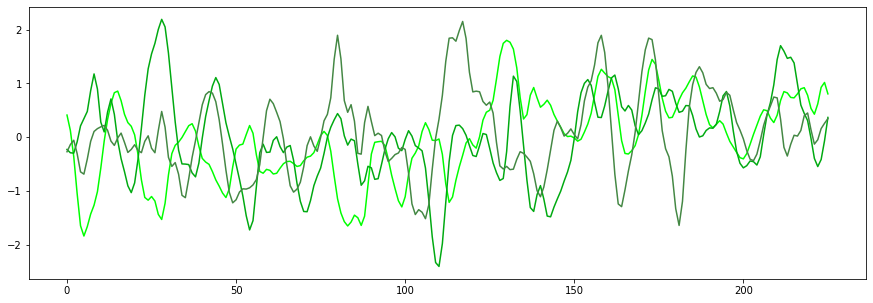

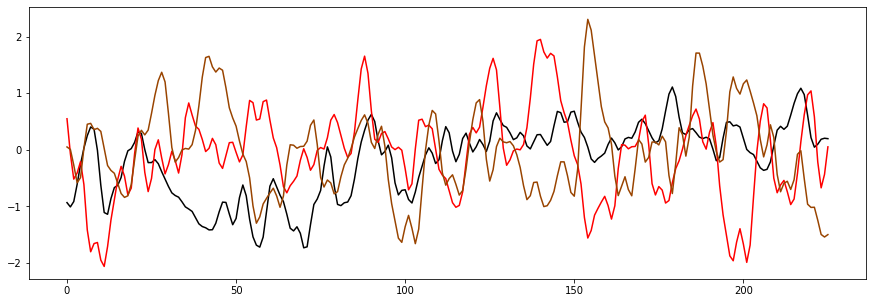

In [ ]:
rcParams['figure.figsize'] = 15, 5

plt.plot(list(range(0, eeg_sample_length)), positive_testing_data[0], color = "#00ff00")
plt.plot(list(range(0, eeg_sample_length)), positive_testing_data[1], color = "#00aa11")
plt.plot(list(range(0, eeg_sample_length)), positive_testing_data[2], color = "#448844")
plt.show()
plt.plot(list(range(0, eeg_sample_length)), negative_testing_data[0], color = "black")
plt.plot(list(range(0, eeg_sample_length)), negative_testing_data[1], color = "r")
plt.plot(list(range(0, eeg_sample_length)), negative_testing_data[2], color = "#994400")
plt.show()

So what happened here? The black line on the second graph is our offender. Visually, it looks similar enough to the Positive samples that it could easily be mistaken for one. Our network would require siginificantly more examples before it could distinguish samples like this.

Generally, it's recommended to have at least 100 samples to train on for each class. In this case we only had 9! Not enough for a true application, but enough for a proof of concept. With more samples, the network can develop a more complex and robust solution to classification.

# Analyse of the collected data

Here, we'd like to train the EEG data collected just now.
First, we should load the .mat data and get EEG data and its corresponding labels.

***When data is used with standardised format and meta-data MNE does not needed to process data at all***

In [ ]:
import scipy.io as sio

In [ ]:
bciworkshop = {'participants':70,'day':'Wednesday'}

In [ ]:
bciworkshop.keys()

dict_keys(['participants', 'day'])

In [ ]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
P300_file_3 = sio.loadmat('/P300Data3.mat')
#print('P300 file contents',P300_file.keys())
P300_data_3 = P300_file_3['Data']
# select the 5-th channel as the training data
P300_data_c5 = P300_data_3[4, :].transpose()

## NORMALIZING
scaler = MinMaxScaler()
scaler.fit(P300_data_c5)

P300_data_c5 = scaler.transform(P300_data_c5)

P300_label = P300_file_3['Labels']



from sklearn.model_selection import train_test_split
P300_data_c5_train, P300_data_c5_test, P300_label_c5_train, P300_label_c5_test = train_test_split(P300_data_c5, P300_label, test_size=0.2, random_state=123)

print(P300_data_c5_train.shape)
print(P300_data_c5_test.shape)

(200, 750)
(50, 750)


In [ ]:
## Define the network
P300_model = keras.Sequential()

# Input Layer (Size 226 -> 500)
P300_model.add(layers.Dense(hidden1, activation="relu", name="Input_Layer"))

# Hidden Layer (Size 500 -> 1000)
P300_model.add(layers.Dense(hidden2, activation="relu", name="Hidden_Layer1"))

# Hidden Layer (Size 1000 -> 100)
P300_model.add(layers.Dense(hidden3, activation="relu", name="Hidden_Layer2"))

# Hidden Layer (Size 100 -> 10)
P300_model.add(layers.Dense(penultimate, activation="relu", name="Hidden_Layer3"))

# Output Layer (Size 10 -> 1)
P300_model.add(layers.Dense(number_of_classes, activation="sigmoid", name="Output_Layer"))

# Define a learning function, needs to be reinitialized every load
optimizer = keras.optimizers.Adam(lr=0.001)
# After the model is created, we then config the model with losses and metrics
P300_model.compile(optimizer=optimizer,
             loss='mse',
             metrics=['mse'])

Below is the loss graph for dataset training session


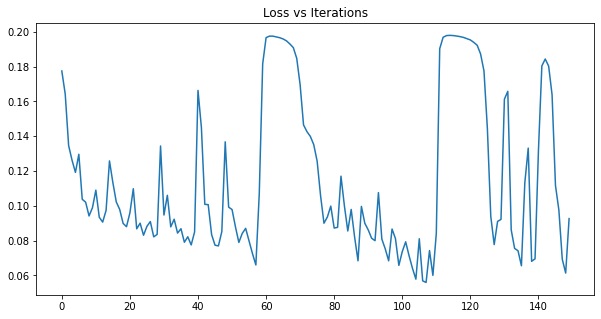

In [ ]:
# Make sure we're starting from untrained every time
#tutorial_model = keras.models.load_model('/home/tutorial_model_default_state')
#tf.compat.v1.initializers.global_variables()
mse_list = P300_model.fit(P300_data_c5_train, P300_label_c5_train, epochs = 150, verbose=0)

# Define a learning function, needs to be reinitialized every load
# optimizer = torch.optim.Adam(tutorial_model.parameters(), lr = learning_rate)

# Use our training procedure with the sample data
print("Below is the loss graph for dataset training session")
loss_data = mse_list.history['loss']
# Plot a nice loss graph at the end of training
rcParams['figure.figsize'] = 10, 5
plt.title("Loss vs Iterations")
plt.plot(list(range(0, len(loss_data))), loss_data)
plt.show()

In [ ]:
# Classify our positive test dataset and print the results
classification_test = np.round(P300_model.predict(P300_data_c5_test))
from sklearn.metrics import classification_report
print(classification_report(P300_label_c5_test, classification_test))


              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.89      0.97      0.93        40

    accuracy                           0.88        50
   macro avg       0.86      0.74      0.78        50
weighted avg       0.88      0.88      0.87        50

